In [15]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import os
import umap.umap_ as umap

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import distinctipy

import warnings
# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading the data

In [2]:
# Load data
try:
    # load the metadata
    metadata_df = pd.read_csv("metadata.csv")
    title_embeddings = np.load("metadata_title_embeddings.npz")["embeddings"]
    keywords_embeddings = np.load("metadata_keywords_embeddings.npz")["embeddings"]
    
    # load the annotations
    annotations_df = pd.read_csv("annotations.csv")
    annotations_embeddings = np.load("annotations_text_embeddings.npz")["embeddings"]
    
    print(f"Successfully loaded dataset with {len(metadata_df)} audio files and {len(annotations_df)} annotations")
    
    print(annotations_text_embeddings.shape)  # should be (n_samples, embedding_dim)
    print(annotations_text_embeddings[:2])    # preview a couple rows
    
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please check that all files exist and paths are correct.")

Successfully loaded dataset with 9026 audio files and 35826 annotations
Error loading data: name 'annotations_text_embeddings' is not defined
Please check that all files exist and paths are correct.


# (a) Clustering the text features:

In [24]:
# Combine keyword and title embeddings
metadata_embeddings = np.concatenate((keywords_embeddings, title_embeddings), axis=1)  # Concatenate

# Step 1: Reduce both metadata and annotation embeddings to the same dimensionality
target_dim = 1024  # Set target dimension to match annotations_embeddings

# Apply PCA to reduce metadata_embeddings to target_dim
pca_metadata = PCA(n_components=target_dim)
metadata_reduced = pca_metadata.fit_transform(metadata_embeddings)

# Apply PCA to reduce annotations_embeddings to target_dim
pca_annotations = PCA(n_components=target_dim)
annotations_reduced = pca_annotations.fit_transform(annotations_embeddings)

# Step 2: Concatenate the reduced embeddings
all_embeddings = np.concatenate((metadata_reduced, annotations_reduced), axis=0)




In [45]:
metadata_embeddings = np.concatenate((keywords_embeddings, title_embeddings), axis=1)  # Concatenate
all_embeddings = metadata_embeddings

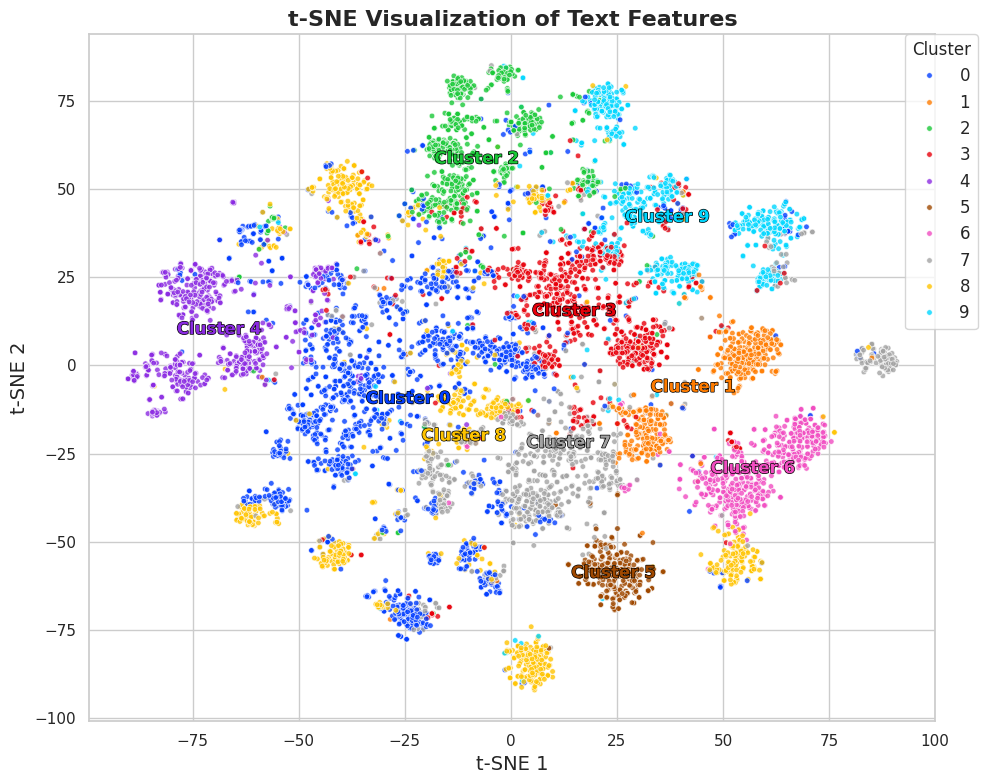

In [49]:
# Step 3: Apply clustering (e.g., K-Means)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
all_clusters = kmeans.fit_predict(all_embeddings)

# Step 4: Visualize (e.g., t-SNE)
tsne = TSNE(n_components=2)
all_tsne = tsne.fit_transform(all_embeddings)

# Plotting

# Create a DataFrame for the plot
plot_df = pd.DataFrame(all_tsne, columns=['TSNE1', 'TSNE2'])
plot_df['Cluster'] = all_clusters

# Define colors
sns.set(style="whitegrid")
palette = sns.color_palette("bright", n_colors=num_clusters)  # 5 distinct colors for clusters

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='TSNE1', y='TSNE2', hue='Cluster', data=plot_df, palette=palette,
    s=16, edgecolor='w', linewidth=0.5, marker='o', alpha=0.8
)

# Add cluster labels at the center of each cluster
for cluster_num in range(num_clusters):
    # Get the centroid of each cluster
    cluster_data = plot_df[plot_df['Cluster'] == cluster_num]
    centroid = cluster_data[['TSNE1', 'TSNE2']].mean()
    
    # Annotate the centroid
    plt.text(
    centroid[0], centroid[1], f'Cluster {cluster_num}', 
    horizontalalignment='center', verticalalignment='center', 
    fontsize=12, fontweight='bold', color=palette[cluster_num],
    path_effects=[
        path_effects.Stroke(linewidth=1, foreground='black'),
        path_effects.Normal()
    ])

# Enhance plot aesthetics
plt.title('t-SNE Visualization of Text Features', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=12)

# Show grid for better clarity
plt.grid(True)

# Show plot
plt.tight_layout()
plt.savefig(f"text_features_clusters_tsne_{num_clusters}.png", dpi=300, bbox_inches='tight')
plt.show()

/home/TG/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/TG/anaconda3/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/TG/anaconda3/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/TG/anaconda3/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Fal

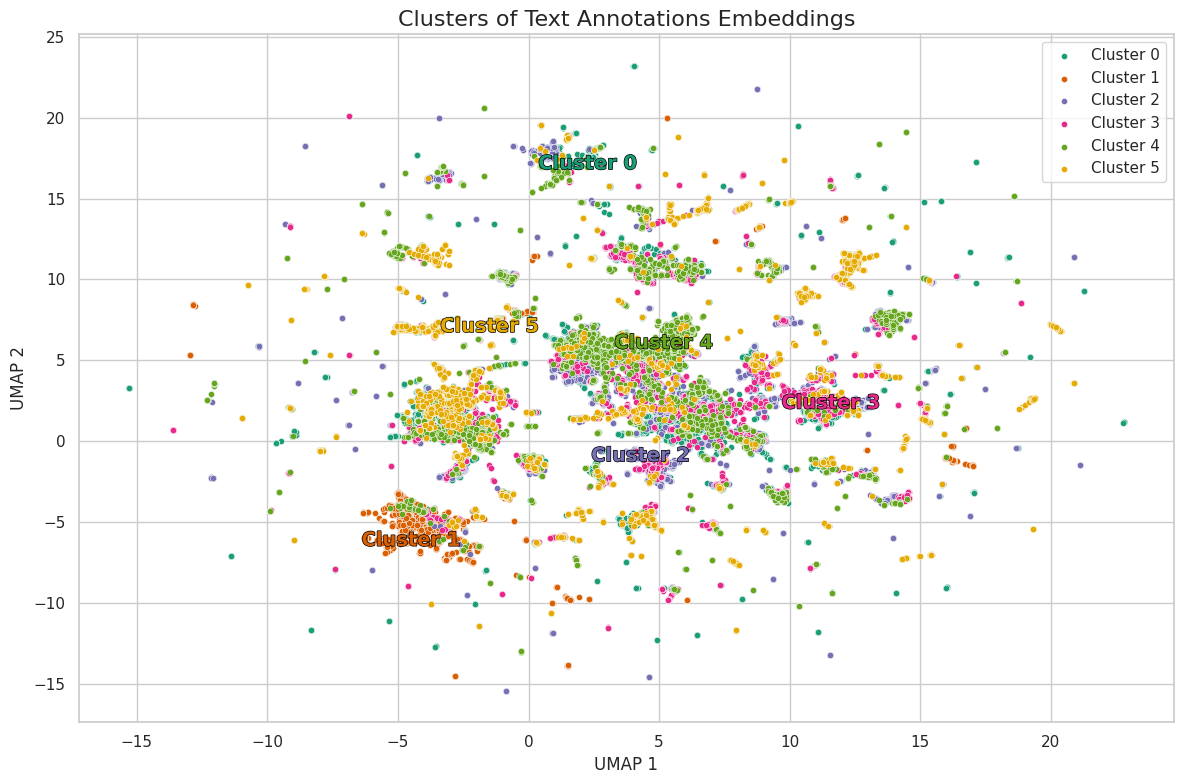

In [5]:
# Choose which embeddings to cluster
embeddings = annotations_embeddings  # or keywords_embeddings / title_embeddings

# Dimensionality reduction
reducer = umap.UMAP(random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)
                                      
# Clustering
n_clusters = 6  # tweak
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Visualization
plt.figure(figsize=(12, 8))
palette = sns.color_palette("Dark2", n_clusters)

# Plot each point
for cluster_num in range(n_clusters):
    cluster_points = embeddings_2d[cluster_labels == cluster_num]
    sns.scatterplot(
        x=cluster_points[:, 0], y=cluster_points[:, 1],
        s=20, label=f'Cluster {cluster_num}',
        color=palette[cluster_num % len(palette)]
    )

# Annotate cluster centroids
centroids_2d = reducer.transform(kmeans.cluster_centers_)
for cluster_num, centroid in enumerate(centroids_2d):
    txt = plt.text(
        centroid[0], centroid[1], f'Cluster {cluster_num}',
        horizontalalignment='center', verticalalignment='center',
        fontsize=14, fontweight='bold', color=palette[cluster_num % len(palette)],
        path_effects=[
            path_effects.Stroke(linewidth=1, foreground='black'),
            path_effects.Normal()
        ]
    )

plt.title("Clusters of Text Annotations Embeddings", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.tight_layout()
plt.savefig("annotations_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

/home/TG/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


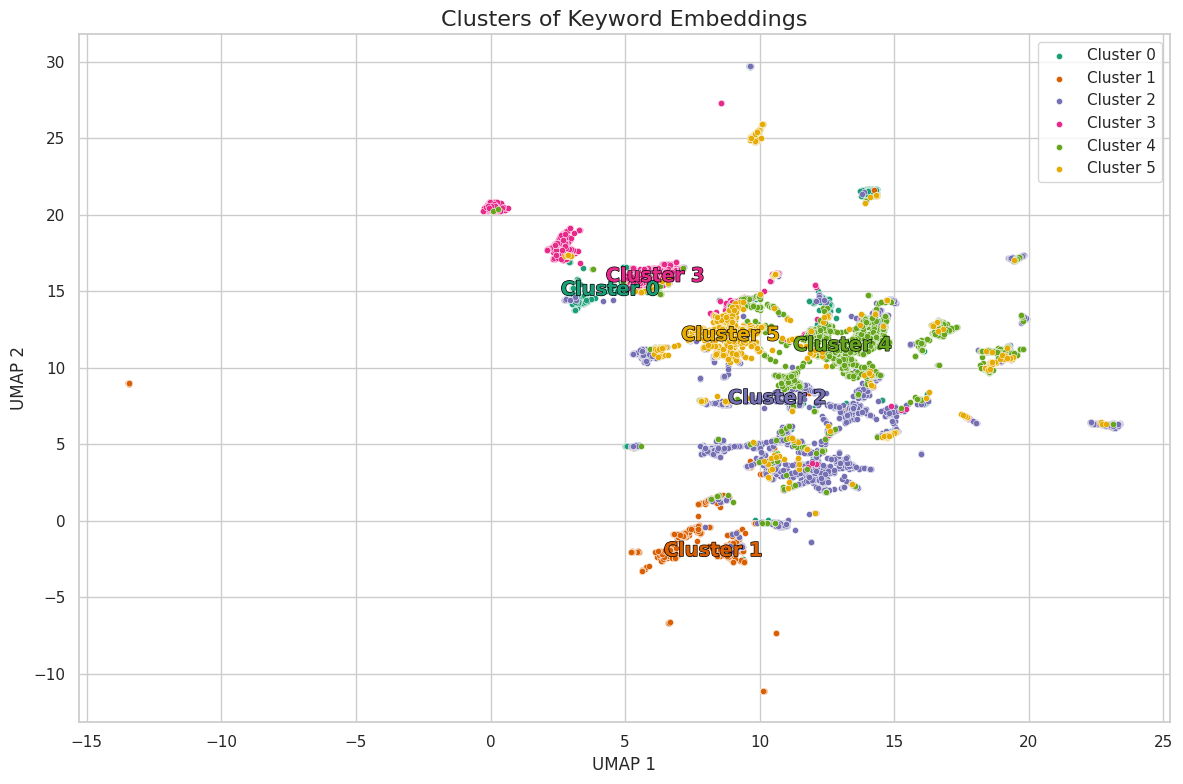

In [6]:
# Choose which embeddings to cluster
embeddings = keywords_embeddings # or annotations_embeddings / title_embeddings

# Dimensionality reduction
reducer = umap.UMAP(random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# Clustering
n_clusters = 6  # final
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Visualization
plt.figure(figsize=(12, 8))
palette = sns.color_palette("Dark2", n_clusters)

# Plot each point
for cluster_num in range(n_clusters):
    cluster_points = embeddings_2d[cluster_labels == cluster_num]
    sns.scatterplot(
        x=cluster_points[:, 0], y=cluster_points[:, 1],
        s=20, label=f'Cluster {cluster_num}',
        color=palette[cluster_num % len(palette)]
    )

# Annotate cluster centroids
centroids_2d = reducer.transform(kmeans.cluster_centers_)
for cluster_num, centroid in enumerate(centroids_2d):
    txt = plt.text(
        centroid[0], centroid[1], f'Cluster {cluster_num}',
        horizontalalignment='center', verticalalignment='center',
        fontsize=14, fontweight='bold', color=palette[cluster_num % len(palette)],
        path_effects=[
            path_effects.Stroke(linewidth=1, foreground='black'),
            path_effects.Normal()
        ]
    )

plt.title("Clusters of Keyword Embeddings", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.tight_layout()
plt.savefig("keywords_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

/home/TG/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


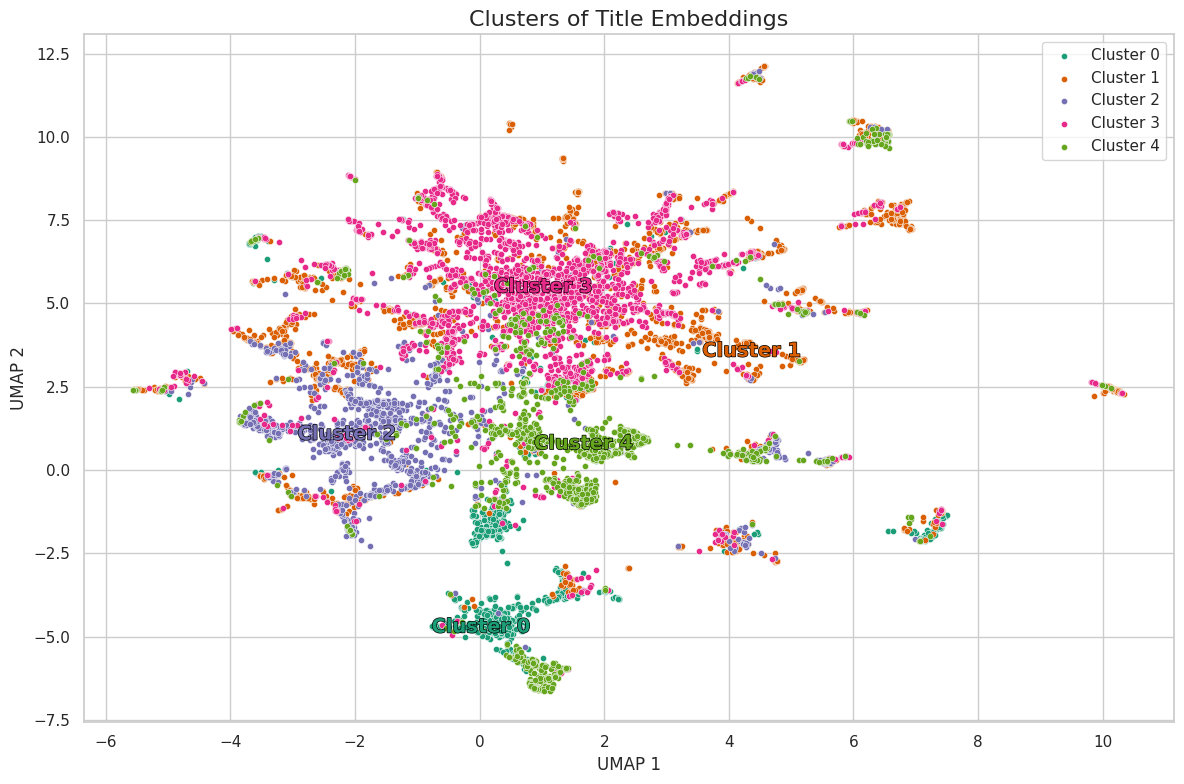

In [21]:
# Choose which embeddings to cluster
embeddings = title_embeddings # or annotations_embeddings / keywords_embeddings

# Dimensionality reduction
reducer = umap.UMAP(random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# Clustering
n_clusters = 5  # tweak 4-5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Visualization
plt.figure(figsize=(12, 8))
palette = sns.color_palette("Dark2", n_clusters)

# Plot each point
for cluster_num in range(n_clusters):
    cluster_points = embeddings_2d[cluster_labels == cluster_num]
    sns.scatterplot(
        x=cluster_points[:, 0], y=cluster_points[:, 1],
        s=20, label=f'Cluster {cluster_num}',
        color=palette[cluster_num % len(palette)]
    )

# Annotate cluster centroids
centroids_2d = reducer.transform(kmeans.cluster_centers_)
for cluster_num, centroid in enumerate(centroids_2d):
    txt = plt.text(
        centroid[0], centroid[1], f'Cluster {cluster_num}',
        horizontalalignment='center', verticalalignment='center',
        fontsize=14, fontweight='bold', color=palette[cluster_num % len(palette)],
        path_effects=[
            path_effects.Stroke(linewidth=1, foreground='black'),
            path_effects.Normal()
        ]
    )

plt.title("Clusters of Title Embeddings", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.tight_layout()
plt.savefig("titles_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

# (b) Creating a labeling function for classes *dog* and *cat* :

In [8]:
# Labeling Function for "dog" and "cat"
def label_dog_cat(text):
    text = text.lower()
    if 'dog' in text or 'bark' in text or 'woof' in text:
        return 'dog'
    elif 'cat' in text or 'meow' in text or 'purr' in text:
        return 'cat'
    else:
        return 'other'

In [9]:
# Apply labeling function
annotations_df['label'] = annotations_df['text'].apply(label_dog_cat)
annotations_df['label'].value_counts()

label
other    33255
dog       1653
cat        918
Name: count, dtype: int64

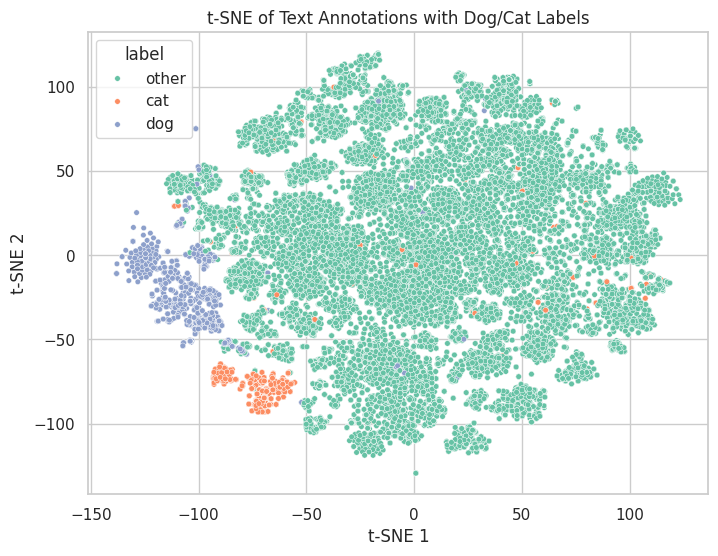

In [10]:
# Clustering of Dog and Cat Labels in Text Feature Space
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(annotations_embeddings)

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=annotations_df['label'], s=16, palette='Set2')
plt.title("t-SNE of Text Annotations with Dog/Cat Labels")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.savefig("text_dogcat.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Apply labeling function
metadata_df['label'] = metadata_df['keywords'].apply(label_dog_cat)
metadata_df['label'].value_counts()

label
other    8389
cat       335
dog       302
Name: count, dtype: int64

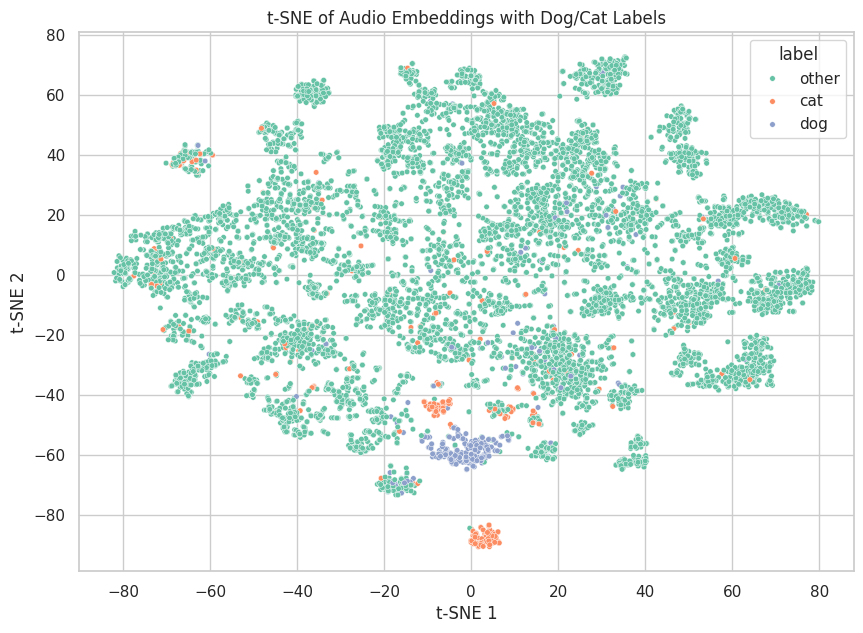

In [12]:
# Load audio embeddings
embeddings = []
for i in range(len(metadata_df)):
    feature_filename = metadata_df.loc[i, "filename"].replace("mp3", "npz")
    features = np.load(os.path.join("audio_features", feature_filename))
    emb = features["embeddings"]
    mean_emb = np.mean(emb, axis=0)  # mean pooling
    embeddings.append(mean_emb)

# Convert to array
X = np.vstack(embeddings)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=metadata_df['label'], s=16, palette='Set2')
plt.title("t-SNE of Audio Embeddings with Dog/Cat Labels")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.savefig("audio_dogcat.png", dpi=300, bbox_inches='tight')
plt.show()